<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/nn/recurrent-neural-networks-and-speechbrain.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/nn/recurrent-neural-networks-and-speechbrain.ipynb)

# Recurrent Neural Networks

Recurrent Neural Networks (RNNs) provide a natural approach for processing sequences.

In most cases, the elements of a sequence are not independent. The emission of a particular output often depends on the surrounding elements or even the entire history.

To adequately model the sequence evolution, the presence of **memory** is crucial to keep track of past or future elements. Memory is implemented using **feedback connections**, introducing the concept of "state." RNNs rely on the following equation:

$ h_t = f(x_t, h_{t−1}, θ)$

where \(h_t\) and \(h_{t−1}\) are the current and previous states, and \(θ\) represents the trainable parameters.

Due to this recurrence, the current state depends on the previous one, and the previous one depends on the element before, creating a dependency on all previous elements.

## 1. Vanilla RNN

The simplest form of RNN is the vanilla RNN, described by the following equation:

$ h_t = \tanh(W x_t + Uh_{t−1} + b) $

Here, the parameters \(θ\) include the weight matrix \(W\) (feed-forward connections), the matrix \(U\) (recurrent weights), and the vector \(b\) (bias).

To train an RNN, a network **unfolding over the time** axis is necessary, as illustrated in the following figure:

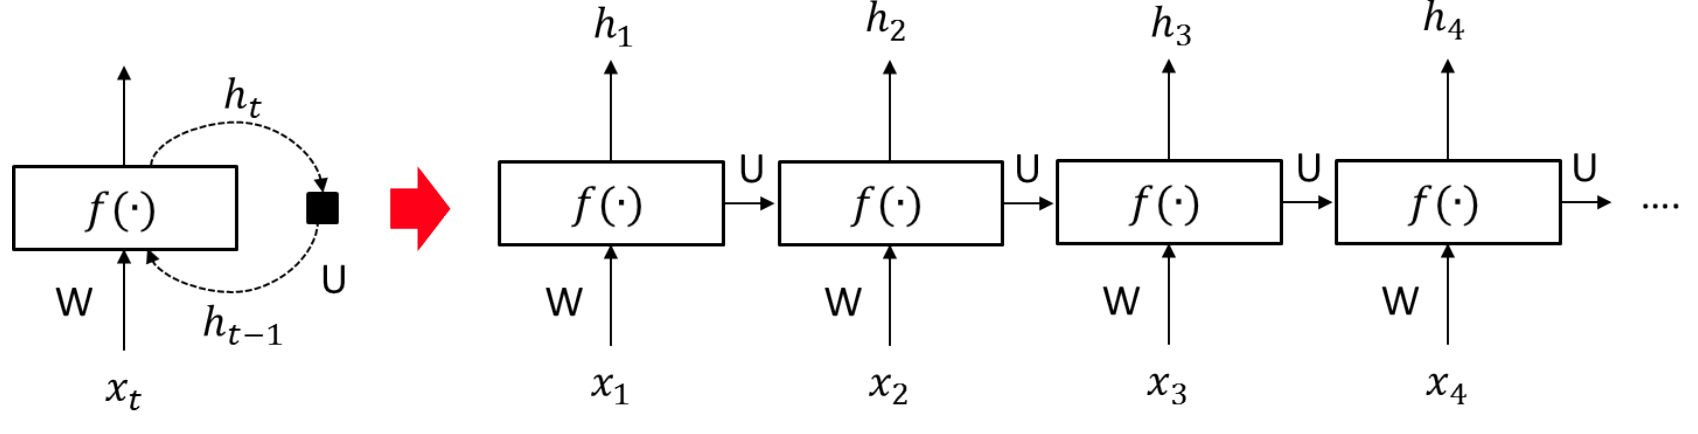

After unfolding, the RNN can be treated as a feed-forward neural network, that is very **deep along the time axes**.
Therefore, the same algorithms adopted for training feed-forward neural networks can be used. Sometimes, the back-propagation algorithm in the context of recurrent neural networks is called **back-propagation through time**, to emphasize that the gradient is propagated through the time axes.

An important aspect of RNNs is that the **parameters are shared across the time steps**, making model generalization easier.
Let's now take a look into a Vanilla RNN using SpeechBrain. First of all, let's install it and download some test data.

In [1]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

SpeechBrain has a bunch of RNNs implemented in `speechbrain.nnet.RNN`. Let's see an example with a vanilla RNN:

In [2]:
import torch
from speechbrain.nnet.RNN import RNN

inp_tensor = torch.rand([4, 10, 20]) # [batch, time, features]
net = RNN(hidden_size=5, input_shape=inp_tensor.shape)
out_tensor, _ = net(inp_tensor)

print(out_tensor.shape)

torch.Size([4, 10, 5])


As you can see, the expected input must be formatted as $[batch, time, features]$. This is a standard followed by all the neural networks implemented in SpeechBrain.

The output has the same number of batch (i.e., four), the same number of time-steps (i.e., 10), and the transform feature dimension (which in this case is five like the selected hidden_size).

Let's now take a look into the parameters:

In [3]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

rnn.weight_ih_l0 torch.Size([5, 20])
rnn.weight_hh_l0 torch.Size([5, 5])
rnn.bias_ih_l0 torch.Size([5])
rnn.bias_hh_l0 torch.Size([5])



*   The first parameter is the matrix $W$ (input-to-hidden) with dimension $[5, 20]$, where five is the hidden size, and 20 is the input dimension.
*   The second parameter is $U$ (hidden-to-hidden) that corresponds to the recurrent weights. It is always a square matrix. In this case, the dimensionality is $[5,5]$ because of the selected hidden dimension.
* Finally, we have a couple of vectors composed of hidden_dim elements. These two tensors represent the bias term $b$. In this case, the term is split into two biases (one for the input and one for the recurrent connections). In other cases, a single bias (that embeds both) is used.


When setting  **bidirectional=True**, a bidirectional RNN is used:

In [4]:
inp_tensor = torch.rand([4, 10, 20]) # [batch, time, features]
net = RNN(hidden_size=5,
          input_shape=inp_tensor.shape,
          bidirectional=True
          )
out_tensor, _ = net(inp_tensor)

print(out_tensor.shape)

torch.Size([4, 10, 10])


In this case, we have two independent neural networks that scans the input sequence left-to-right and right-to-left. The resulting hidden states are then concatenated in a single "**bidirectional**" tensor. In the example, the feature dimension is now 10, which corresponds to two times the original hidden dimension.

In the previous examples, we use a single layer RNN. We can make the model deeper in the feature dimension just by stacking more layers:

In [5]:
inp_tensor = torch.rand([4, 10, 20]) # [batch, time, features]
net = RNN(hidden_size=5,
          input_shape=inp_tensor.shape,
          bidirectional=True,
          num_layers=3,
          )
out_tensor, _ = net(inp_tensor)

print(out_tensor.shape)

torch.Size([4, 10, 10])


RNNs requires back-propagating the gradient through many time steps. This operation, however, can be complicated by vanishing and exploding gradients. These issues impair learning long-term dependencies.

*   **Exploding gradient** can be tackled with simple clipping strategies.

* **Vanishing gradient**, instead, is more critical. It could be attenuated by adding "gradient shortcuts" in the network design (think about residual networks, skip connections, or even attention mechanisms).

A common approach for RNNs relies on **multiplicative gates**, whose core idea is to introduce a mechanism for better controlling the flow of information through the various time-steps.

The most popular network relying on gating mechanism is the Long-Short Term Memory (LSTM) that will be described in the following.

## 2. Long-Short Term Memory (LSTM)



LSTMs rely on a network design consisting of memory cells that are controlled by forget, input, and output gates:

$f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)$

$i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)$

$o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)$

$\widetilde{c}_t = \sigma(W_c x_t + U_c h_{t-1} + b_c)$

$c_t = f_t \cdot c_{t-1} + i_t \cdot \widetilde{c}_t $

$h_t = o_t \cdot \sigma(c_t)$,

where $\sigma$ is the sigmoid function.

As you can see, the network design is quite complex, but this model turned out to be very general-purpose.

The easiest way to see why this model can learn** long-term dependencies** is the following: with proper values of the f_t, i_t, and o_t, we can store the internal cell state $c_t$ for an arbitrary number of time steps (if $f_t = 1$ and $i_t=0$).

Let's see how to use an LSTM within SpeechBrain:

In [6]:
import torch
from speechbrain.nnet.RNN import LSTM

inp_tensor = torch.rand([4, 10, 20]) # [batch, time, features]
net = LSTM(hidden_size=5, input_shape=inp_tensor.shape)
out_tensor, _ = net(inp_tensor)

print(out_tensor.shape)

torch.Size([4, 10, 5])


As you can see, the dimension in input and output are the same as the vanilla RNN (when using the same hidden_size). The number of parameters, however, is very different:

In [7]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

rnn.weight_ih_l0 torch.Size([20, 20])
rnn.weight_hh_l0 torch.Size([20, 5])
rnn.bias_ih_l0 torch.Size([20])
rnn.bias_hh_l0 torch.Size([20])


As you can see we gather in single big tensors the groups of parameters. For instance, `rnn.weight_ih_l0` gathers all the four input-to-hidden matrixes of dimension [5, 20] for $f$,$i$,$o$,$c$ is a single tensor of dimension $[20,20]$. A similar concatenation is done with the hidden-to-hidden weights `rnn.weight_hh_l0` and the biases.

Similarly to the vanilla RNN, we can use the parameter `bidirectional=True` to employ a bidirectional neural network. We can also stack more layers using the argument `num_layers`.

## 3. Gated Recurrent Units (GRUs)
LSTMs rely on memory cells that are controlled by forgetting, input, and output gates. Despite their effectiveness, such a sophisticated gating mechanism might result in an overly complex model.

A noteworthy attempt to **simplify LSTMs** led to a novel model called Gated Recurrent Unit (GRU), which is based on **two multiplicative gates **only. In particular, the GRU architecture is described by the following equations:

$z_{t}=\sigma(W_{z}x_{t}+U_{z}h_{t-1}+b_{z})$

$r_{t}=\sigma(W_{r}x_{t}+U_{r}h_{t-1}+b_{r})$

$\widetilde{h_{t}} =\tanh(W_{h}x_{t}+U_{h}(h_{t-1} \odot r_{t})+b_{h})$

$h_{t}=z_{t} \odot h_{t-1}+ (1-z_{t}) \odot \widetilde{h_{t}}$.

where $z_{t}$ and $r_{t}$ are vectors corresponding to the update and reset gates, respectively, while $h_{t}$ represents the state vector for the current time frame $t$.
Computations denoted as $\odot$ represent element-wise multiplications.

Similar to LSTM, also GRU is designed to learn long-term dependencies. GRU, in fact, can store the hidden state $h_t$ for an arbitrary number of times steps. This happens when  $z_t = 1$.

Let's now see how we can use a GRU within SpeechBrain:


In [8]:
import torch
from speechbrain.nnet.RNN import GRU

inp_tensor = torch.rand([4, 10, 20]) # [batch, time, features]
net = GRU(hidden_size=5, input_shape=inp_tensor.shape)
out_tensor, _ = net(inp_tensor)

print(out_tensor.shape)

torch.Size([4, 10, 5])


The output tensor has the same size as the vanilla RNN and the LSTM. The parameters inside the model are different:



In [9]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

rnn.weight_ih_l0 torch.Size([15, 20])
rnn.weight_hh_l0 torch.Size([15, 5])
rnn.bias_ih_l0 torch.Size([15])
rnn.bias_hh_l0 torch.Size([15])


Similar to LSTM, also the GRU models gather weight matrixes in bigger tensors. In this case, the weight matrixes are smaller because we have only two gates. You can play with the bidirectional and num_layers to use bidirectional RNN or to employ more layers.

## 4. Light Gated Recurrent Units (LiGRU)

Despite the interesting performance achieved by GRUs, which is normally comparable to that of the LSTMs, a further simplification of the model is possible.

Recently, a model called **light GRU** has been proposed and turned out to perform well on speech processing tasks. The model is based on a single multiplicative gate, and it is described by the following equations:

$z_{t}=\sigma(BN(W_{z}x_{t})+U_{z}h_{t-1})$

$\widetilde{h_{t}}=\mbox{ReLU}(BN(W_{h}x_{t})+U_{h}h_{t-1})$

$h_{t}=z_{t} \odot h_{t-1}+ (1-z_{t}) \odot \widetilde{h_{t}}$

The LiGRU can be derived from the standard GRU model with the following modifications:


1.  **Remove the reset gate**: in speech applications, the reset gate turned out to be redundant. In the LiGRU model, this is thus eliminated without any performance loss. As a result, the neural network is based on a single multiplicative gate only, with benefits on speed, parameters, and memory.
2.   **Use ReLU + BatchNorm** in the the candidate state $\widetilde{h_{t}}$*:
ReLU is the most popular activation function for feedforward neural networks. Differently from *tanh* and `sigmoids` they don't have saturation points that cause small gradients. The adoption of ReLU-based neurons was not so common in the past for the RNN architectures. This was due to numerical instabilities originating from the unbounded ReLU functions applied over long time series.  To circumvent these numerical issues, LiGRU couples it with batch normalization. Batch normalization not only contributes to limit numerical issues but also to improve performance.
3. **shared parameters** When using bidirectional architectures, two independent models are normally employed. The LiGRU, instead, shares the same parameters for both the left-to-right and right-to-left scan. This not only helps to reduce the total amount of parameters but also improves generalization.

Let's see now how to use the LiGRU model in speechbrain:



In [10]:
import torch
from speechbrain.nnet.RNN import LiGRU

inp_tensor = torch.rand([4, 10, 20]) # [batch, time, features]
net = LiGRU(hidden_size=5, input_shape=inp_tensor.shape)
out_tensor, _ = net(inp_tensor)

print(out_tensor.shape)

torch.Size([4, 10, 5])


As you can see the dimension in input and output are the same as the other recurrent models. The number of parameters, instead, is different:



In [11]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

rnn.0.w.weight torch.Size([10, 20])
rnn.0.u.weight torch.Size([10, 5])
rnn.0.norm.weight torch.Size([10])
rnn.0.norm.bias torch.Size([10])


If we employ a bidirectional model, the number of parameters is the same (due to parameter sharing):

In [12]:
import torch
from speechbrain.nnet.RNN import LiGRU

inp_tensor = torch.rand([4, 10, 20]) # [batch, time, features]
net = LiGRU(hidden_size=5,
            input_shape=inp_tensor.shape,
            bidirectional=True)
out_tensor, _ = net(inp_tensor)

print(out_tensor.shape)

for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

torch.Size([4, 10, 10])
rnn.0.w.weight torch.Size([10, 20])
rnn.0.u.weight torch.Size([10, 5])
rnn.0.norm.weight torch.Size([10])
rnn.0.norm.bias torch.Size([10])


Similar to LSTM and GRU, LiGRUs can learn long-term dependency. The hidden state $h_{t}$, for instance, can be store for an arbitrary number of time steps when $z_{t}=1$.

To conclude, let's compare the number of parameters employed by the different models discussed here:

In [13]:
import torch
from speechbrain.nnet.RNN import RNN, LSTM, GRU, LiGRU

hidden_size = 512
num_layers = 4
bidirectional=True

inp_tensor = torch.rand([4, 10, 80]) # [batch, time, features]

rnn = RNN(hidden_size=hidden_size,
          input_shape=inp_tensor.shape,
          bidirectional=bidirectional,
          num_layers=num_layers
          )

lstm = LSTM(hidden_size=hidden_size,
          input_shape=inp_tensor.shape,
          bidirectional=bidirectional,
          num_layers=num_layers
          )

gru = GRU(hidden_size=hidden_size,
          input_shape=inp_tensor.shape,
          bidirectional=bidirectional,
          num_layers=num_layers
          )

ligru = LiGRU(hidden_size=hidden_size,
          input_shape=inp_tensor.shape,
          bidirectional=bidirectional,
          num_layers=num_layers
          )


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("RNN:", count_parameters(rnn)/10e6, "M")
print("RNN:", count_parameters(lstm)/10e6, "M")
print("RNN:", count_parameters(gru)/10e6, "M")
print("RNN:", count_parameters(ligru)/10e6, "M")

RNN: 0.5332992 M
RNN: 2.1331968 M
RNN: 1.5998976 M
RNN: 0.5332992 M


The LiGRU is very **parameter efficient** and, in the bidirectional case, has the same number of parameters as a vanilla RNN (with the advantage of being able to learn long-term dependencies).


**## References**

[1]   S. Hochreiter, J. Schmidhuber, "Long short-term memory. Neural computation", 9, 1735--1780, 1997. [pdf](https://www.bioinf.jku.at/publications/older/2604.pdf)

[2]  J. Chung, C. Gulcehre, K. Cho, Y. Bengio, "Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling", 2014 [ArXiv](https://arxiv.org/abs/1412.3555)

[3]  M. Ravanelli, P. Brakel, M. Omologo, Y. Bengio, "Light Gated Recurrent Units for Speech Recognition", 2018 [ArXiv](https://arxiv.org/abs/1803.10225)

[4]  Y. Bengio; P. Simard; P. Frasconi, "Learning long-term dependencies with gradient descent is difficult", IEEE Transactions on Neural Networks, 1994

[5] M. Ravanelli, "Deep Learning for distant speech recogniton", PhD thesis, 2017 [ArXiv](https://theses.eurasip.org/theses/755/deep-learning-for-distant-speech-recognition/download/)


## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```